Name: Madhusudan Hasbe\
PRN: 22070126061\
TY AIML A3

# ASSIGNMENT 7
---------

# Pneumonia Classification using Chest X-rays based on Convolutional Neural Nets with Hyperparameter Tuning

### Objectives:
1. Study the Pueunmonia dataset.
2. Study CNN in detail with its hyperparameter tuning.
3. Implement the same with google colab.

### Theory:
Pneumonia is a serious lung infection that affects millions of people worldwide. Chest X-rays are commonly used for pneumonia diagnosis, but manual interpretation can be time-consuming and error-prone. Automating the process using CNNs can aid in more accurate and faster diagnosis.

A Convolutional Neural Network (CNN) is well-suited for image classification tasks, as it automatically learns features from the input images through convolutional layers, pooling layers, and fully connected layers. Hyperparameter tuning optimizes a CNN's performance by selecting appropriate values for parameters like the learning rate, batch size, number of filters, and dropout rate.

In [6]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import os

### Dataset:

In [7]:
# Setting up directories for training, validation, and test datasets
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [8]:
# Image data generator with rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Loading the training, validation, and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### CNN Model with Hyperparameter Tuning:

In [9]:
# Define a function to create a CNN model with hyperparameters
def create_model(hp):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compiling the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Hyperparameter Tuning:

In [16]:
# Define hyperparameters for tuning
import keras_tuner as kt

# Set up Keras Tuner
tuner = kt.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=5,
    directory='my_dir',
    project_name='pneumonia_cnn',
    seed=2
)

# Use EarlyStopping to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from my_dir/pneumonia_cnn/tuner0.json


In [19]:
# Start tuning
tuner.search(train_generator,
             epochs=10,
             validation_data=val_generator,
             callbacks=[stop_early])

Trial 4 Complete [00h 04m 06s]
val_accuracy: 0.9375

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 38m 48s


### Final Model Training:
Now that we have the best hyperparameters, we train the model with those

In [20]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")

Best Hyperparameters: {'dropout_rate': 0.2, 'learning_rate': 0.0007391032035357176}


In [21]:
# Train the best model on the training data
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 253ms/step - accuracy: 0.9679 - loss: 0.0908 - val_accuracy: 0.6875 - val_loss: 0.7420
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.7420
Epoch 3/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.9745 - loss: 0.0727 - val_accuracy: 0.6250 - val_loss: 1.3143
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 1.3143
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 251ms/step - accuracy: 0.9767 - loss: 0.0651 - val_accuracy: 0.9375 - val_loss: 0.2023


### Plotting Accuracy and Loss:

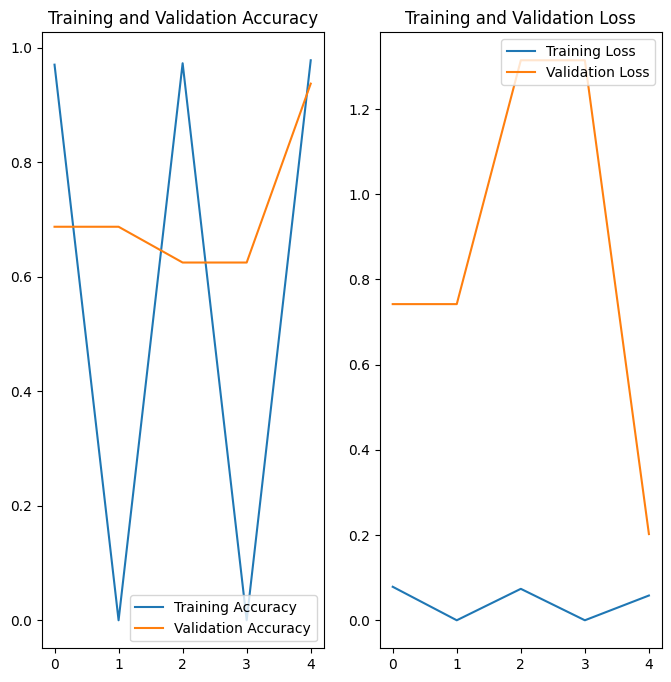

In [23]:
# Plotting accuracy and loss during training and validation
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

### Evaluating the Model:

In [25]:
# Evaluate the model on the test data
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 365ms/step - accuracy: 0.7734 - loss: 1.2189

Test accuracy: 0.7724359035491943


### Conclusion:
In this notebook, we implemented a CNN to classify pneumonia using chest X-ray images and optimized the model through hyperparameter tuning and got test accuracy of 77.24% which is decent. The tuning process helps in finding the optimal values for parameters like batch size, learning rate, and dropout rate, which can significantly improve model performance. CNNs, due to their ability to learn hierarchical feature representations, are very effective for image classification tasks.